Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import Augmentor

In [2]:
!pip install Augmentor

In [15]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [29]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/MelanomaDetection/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/MelanomaDetection/Test")

In [30]:
!ls "/content/drive/MyDrive/MelanomaDetection/Train"

ak  bcc  df  mn  nevus	pgk  scc  sk  vl


In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [36]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['ak', 'bcc', 'df', 'mn', 'nevus', 'pgk', 'scc', 'sk', 'vl']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

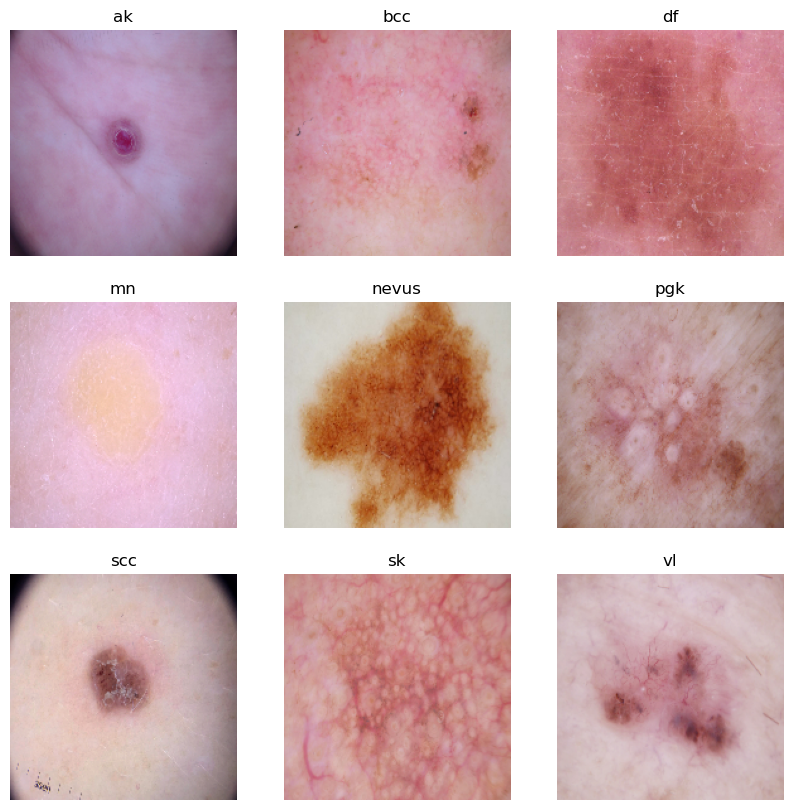

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [43]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
num_classes = 9
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.2446 - loss: 2.0574 - val_accuracy: 0.4407 - val_loss: 1.5958
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.4772 - loss: 1.5572 - val_accuracy: 0.4922 - val_loss: 1.4993
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4877 - loss: 1.4817 - val_accuracy: 0.5302 - val_loss: 1.4043
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.5112 - loss: 1.3485 - val_accuracy: 0.5391 - val_loss: 1.3274
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.5609 - loss: 1.2580 - val_accuracy: 0.4989 - val_loss: 1.3958
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5801 - loss: 1.1607 - val_accuracy: 0.5414 - val_loss: 1.3448
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.6182 - loss: 1.1004 - val_accuracy: 0.5257 - val_loss: 1.4180
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.6541 - loss: 0.9933 - val_accuracy:

### Visualizing training results

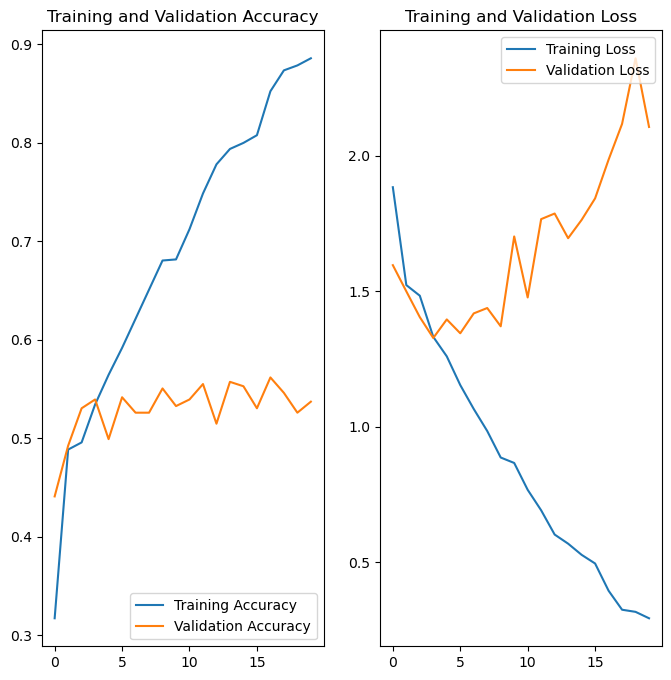

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from first iteration:

#### Validation accuracy is much lower than trainining showing that the model is currently overfit - not learning well. Let's add augmentation to improve learning

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

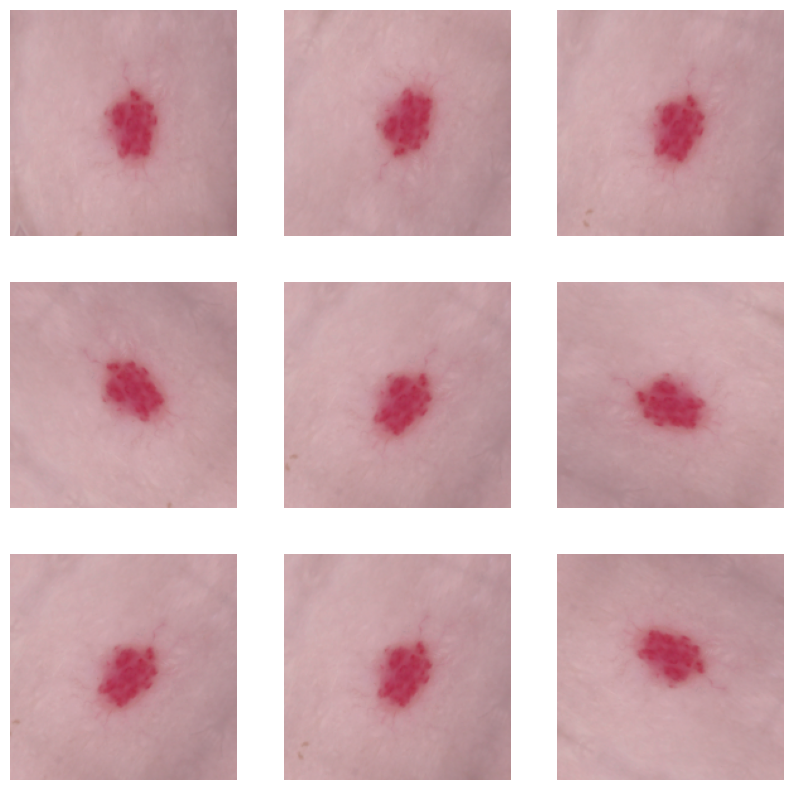

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.2148 - loss: 2.1514 - val_accuracy: 0.3647 - val_loss: 1.7292
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.4073 - loss: 1.6790 - val_accuracy: 0.4787 - val_loss: 1.5067
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.4860 - loss: 1.4865 - val_accuracy: 0.4966 - val_loss: 1.4327
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.4812 - loss: 1.4633 - val_accuracy: 0.4855 - val_loss: 1.4318
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.5045 - loss: 1.3928 - val_accuracy: 0.4698 - val_loss: 1.5164
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.4689 - loss: 1.4692 - val_accuracy: 0.5391 - val_loss: 1.3661
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5221 - loss: 1.3539 - val_accuracy: 0.4966 - val_loss: 1.4161
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.5143 - loss: 1.3434 - val_accu

### Visualizing the results

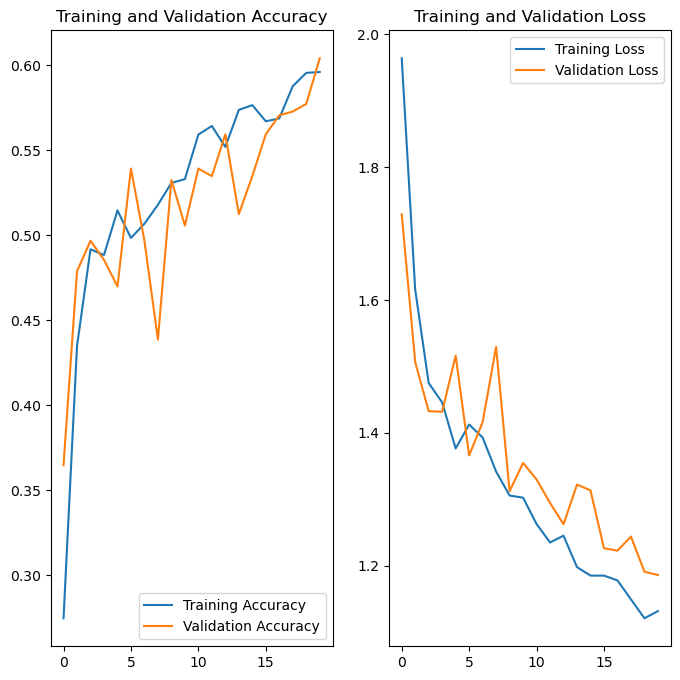

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### We can see that the training accuracy has reduced but validation and training accuracy are very close to each other showing that we have solved the overfitting issue. Next we will work on improving the training accuracy.

#### Let's see the distribution of classes in the dataset

In [ ]:
for name in class_names:
    current_dir = os.path.join(data_dir_train,name)
    print(name, len([name for name in os.listdir(current_dir)]))

ak 114
bcc 376
df 95
mn 438
nevus 357
pgk 462
scc 181
sk 77
vl 139


#### - We can see that the df class: "DermatoFibroma" has least number of samples
#### - pgk -> Pigmented Benign Keratosis dominates the dataset with most number of sample


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset= str(data_dir_train)+'/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/ak/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F468C2D7C10>: 100%|██████████| 500/500 [00:06<00:00, 78.64 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/bcc/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F468C4157E0>: 100%|██████████| 500/500 [00:06<00:00, 78.35 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/df/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F468ECB9FC0>: 100%|██████████| 500/500 [00:05<00:00, 99.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/mn/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F468C31BAF0>: 100%|██████████| 500/500 [00:14<00:00, 33.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F468C172E30>: 100%|██████████| 500/500 [00:14<00:00, 34.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/pgk/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F468EC5BE50>: 100%|██████████| 500/500 [00:05<00:00, 98.00 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/scc/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F468C2F31F0>: 100%|██████████| 500/500 [00:05<00:00, 97.09 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/sk/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F473A245A20>: 100%|██████████| 500/500 [00:06<00:00, 71.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDetection/Train/vl/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F468C287400>: 100%|██████████| 500/500 [00:06<00:00, 82.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
for name in class_names:
    current_dir = os.path.join(data_dir_train,name,'output')
    print(name, len([name for name in os.listdir(current_dir)]))

ak 500
bcc 500
df 500
mn 500
nevus 500
pgk 500
scc 500
sk 500
vl 500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [50]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [52]:
normalize = layers.Normalization()

#### **Todo:** Create your model (make sure to include normalization)

In [53]:
normalize.adapt(train_ds.map(lambda x, y: x))

In [55]:
num_classes = 9
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  normalize,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [57]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.2250 - loss: 1.9940 - val_accuracy: 0.4053 - val_loss: 1.5919
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.4369 - loss: 1.4764 - val_accuracy: 0.4774 - val_loss: 1.4399
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5078 - loss: 1.3155 - val_accuracy: 0.5226 - val_loss: 1.2846
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.5521 - loss: 1.1903 - val_accuracy: 0.5642 - val_loss: 1.1703
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6106 - loss: 1.0457 - val_accuracy: 0.5679 - val_loss: 1.1320
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6579 - loss: 0.9191 - val_accuracy: 0.6392 - val_loss: 0.9734
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7173 - loss: 0.7813 - val_accuracy: 0.6667 - val_loss: 0.9307
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7433 - loss: 0.7033 -

#### Visualize the model results

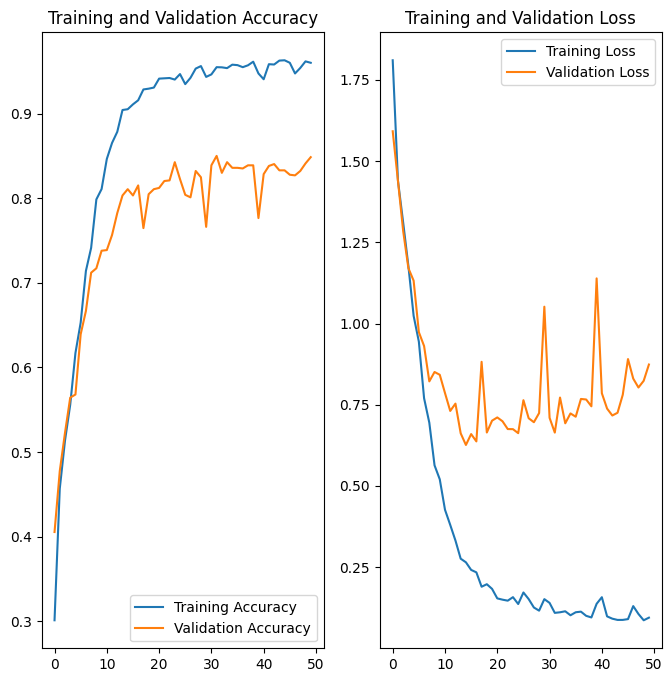

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We were able to drastically increase the value of training and validation accuracy however the difference between the training and validation accuracy is still high. This differnce can be further reduced by doing better class imbalance rectification. We can introduce various types of random transformations to further generalize the data.

### Let's check the test accuracy finally

In [61]:
model.save("/content/drive/MyDrive/MelanomaDetection/final_model.h5")

In [62]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [64]:
testClasses = test_ds.class_names

In [66]:
autotune = tf.data.experimental.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

In [79]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = 1)])
  #print(predictions)
  #print(y)
  labels = np.concatenate([labels, y.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [82]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

4/4 - 1s - 126ms/step - accuracy: 0.3305 - loss: 8.9141


We can see that the test accuracy is low meaning that model has not generalized well and needs further training and more augmentation